# ****Overview****
**Goal:**   Develop a model to predict a company's probability of default (PD) based on its financial ratios.

**Data:**    
*   Historical financial ratios of public companies during the 1995-2004 period, and
*   Historical default events of public companies during the 1995-2004 period.

**Features Definition:**
* WC2TA: Working capital/Total assets
* RE2TA: Retained earning/Total assets
* EBIT2TA: EBIT/Total Assets
* ME2TL: Market Equity/Total Liabilities
* S2TA: Sales/Total assets
* Default: 1 for defaut events, 0 for non-default events

In [18]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Cleaning**

In [2]:
# Importing the data
comp_data = pd.read_table("/Users/hoale/Code/Predicting PD by financial ratios/comp_data.txt", sep="|")
comp_data.head()

,ID,Year,Default,WC2TA,RE2TA,EBIT2TA,ME2TL,S2TA
0,1,1999,0,0.501,0.307,0.043,0.956,0.335
1,1,2000,0,0.550,0.320,0.050,1.060,0.330
2,1,2001,0,0.450,0.230,0.030,0.800,0.250
3,1,2002,0,0.310,0.190,0.030,0.390,0.250
4,1,2003,0,0.450,0.220,0.030,0.790,0.280


In [3]:
comp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       3900 non-null   int64  
 1   Year     3900 non-null   int64  
 2   Default  3900 non-null   int64  
 3   WC2TA    3900 non-null   float64
 4   RE2TA    3900 non-null   float64
 5   EBIT2TA  3900 non-null   float64
 6   ME2TL    3900 non-null   float64
 7   S2TA     3900 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 243.9 KB


In [4]:
comp_data.describe()

,ID,Year,Default,WC2TA,RE2TA,EBIT2TA,ME2TL,S2TA
count,3900.000000,3900.00000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,359.037179,1999.83641,0.018462,0.141708,0.210107,0.051708,1.947132,0.304094
std,199.858753,2.75044,0.134630,0.170903,0.322157,0.029288,3.021428,0.207658
min,1.000000,1995.00000,0.000000,-2.240000,-3.310000,-0.590000,0.020000,0.040000
25%,187.750000,1998.00000,0.000000,0.030000,0.090000,0.040000,0.620000,0.170000
50%,367.000000,2000.00000,0.000000,0.115000,0.220000,0.050000,1.130000,0.260000
75%,524.000000,2002.00000,0.000000,0.240000,0.370000,0.060000,2.212500,0.370000
max,830.000000,2004.00000,1.000000,0.770000,1.640000,0.200000,60.610000,5.010000


* The comp_data dataset contains 5 features and 1 target value.
* There are 3900 rows of data for 830 companies, each of which is represented by one ID.
* There is no missing data.
* We will change the data type of "Year" and "Default" to *datetime* and *categorical*, respectively.

In [5]:
# Convert the features' data types
comp_data['Default'] = comp_data['Default'].astype('category')
comp_data['Year'] = pd.to_datetime(comp_data['Year'], format="%Y")


### **General comments on the features**

Although Exploratory Data Analysis is an important step, it will be presented at the end of the notebook to keep our focus on developing and validating the models.

Based on EDA, we can initially identify the linear relationship between each feature and the PD.

  * ME2TL: This feature is *negatively* correlated with PD.
  * RE2TA: This feature is *negatively* correlated with PD.
  * WC2TA: No clear relationship with default status.
  * EBIT2TA: No clear relationship with default status.
  * S2TA: No clear relationship with default status.

# **Modeling**

We will use the following models to predict the companies' PD.

- Logistic Regression 
- Gradient Boosted Tree 

In [6]:
# Assigning the features and default status
X = comp_data[['WC2TA','RE2TA','EBIT2TA','ME2TL','S2TA']]
y = comp_data[['Default']]

# Creating train and test datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score

## *1 - Logistic Regression*

/opt/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt

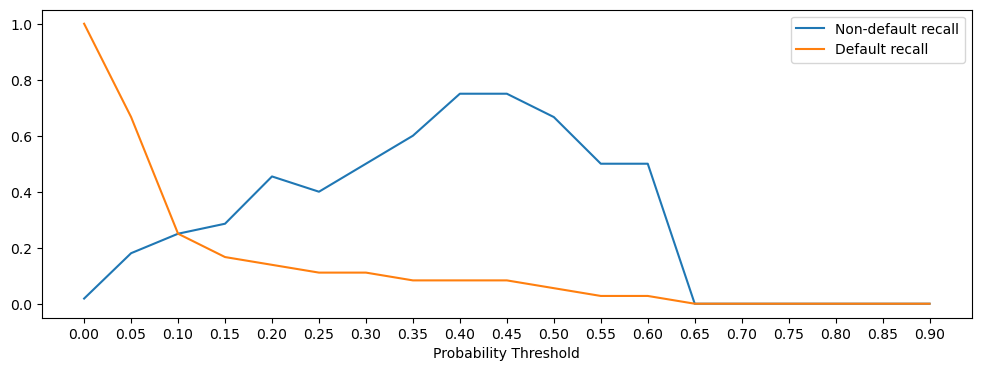

In [7]:
# Splitting the dataset to train and test subsets

random_state = 12
# test_size = [0.1, 0.2, 0.4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = random_state, stratify = y)

# Using Logistic Regression to fit the model on the train dataset

lgr = LogisticRegression(solver='lbfgs')
lgr = lgr.fit(X_train, np.ravel(y_train))

# Predicting the probabilities of default

preds = lgr.predict_proba(X_test)
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Trying different thresholds from 0% to 90% with an increment of 5%

thresholds = np.arange(0.0, 0.95, 0.05)
default_recall = []
nondefault_recall = []

def threshold_assign(i, col_name):
    preds_df[col_name] = preds_df['prob_default'].apply(lambda x: 1 if x > i else 0)

for i in thresholds:
    col_name = "prd_stt_" + str(i)
    threshold_assign(i, col_name)
    def_recall = precision_recall_fscore_support(y_test, preds_df[col_name])[0][1]
    default_recall.append(def_recall)
    nondef_recall = precision_recall_fscore_support(y_test, preds_df[col_name])[1][1]
    nondefault_recall.append(nondef_recall)

# Plotting the default recall and nondefault recalls

plt.figure(figsize = [12,4])
plt.plot(thresholds, default_recall)
plt.plot(thresholds, nondefault_recall)
plt.xlabel('Probability Threshold')
plt.xticks(thresholds)
plt.legend(['Non-default recall', "Default recall"])
plt.show()

## *2 - Gradient Boosted Tree*

In [8]:
# import xgboost as xgb

Validation with ROC and AUC

Calibration

threshold needs to be determined based on the acceptance rate of the portfolio
even though there will still be some default in non-default predictions (accepted loans). this is called "bad rate"

# Exploratory Data Analysis

### WC2TA

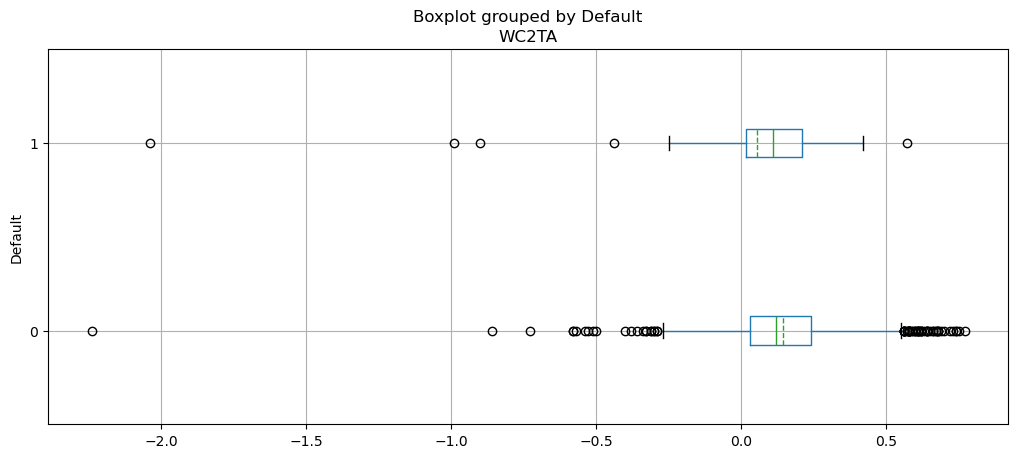

In [9]:
comp_data.boxplot('WC2TA', by='Default', grid=True, vert=False, meanline=True, showmeans=True, figsize=(12,5))
plt.show()

The variance in WC2TA between default and non-default observations is not significant. \
However, default companies tends to have WC2TA closer to 0. \
Most outliers with WC2TA of less than -0.25 or higher than 0.5 are non-defaut companies.

### RE2TA

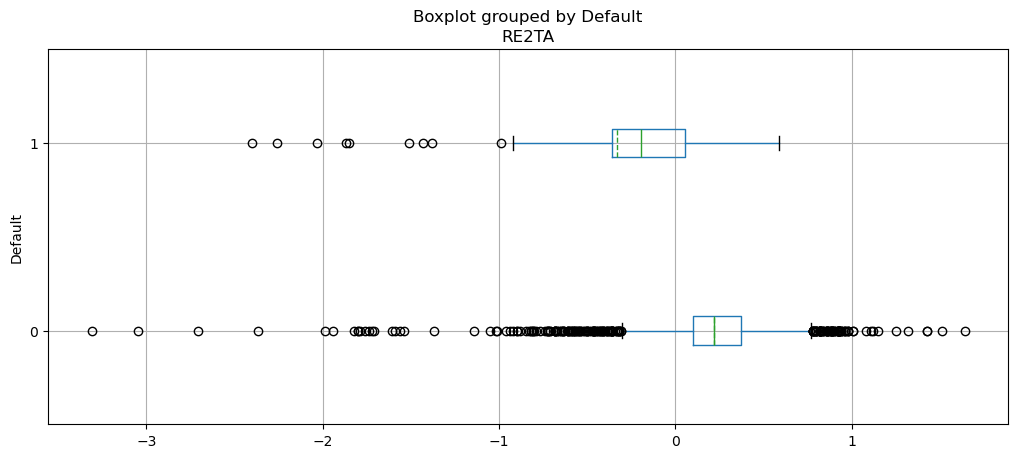

In [10]:
comp_data.boxplot('RE2TA', by='Default', grid=True, vert=False, meanline=True, showmeans=True, figsize=(12,5))
plt.show()

The difference is quite clear with RE2TA. Default companies tend to have a lower RE2TA, with nearly 75% even have negative Retained Earning. Most of non-default companies have a positive RE2TA. However, non-default companies have a noticably wide range of RE2TA. There are many outliers with RE2TA lower than that of default companies.

### EBIT2TA

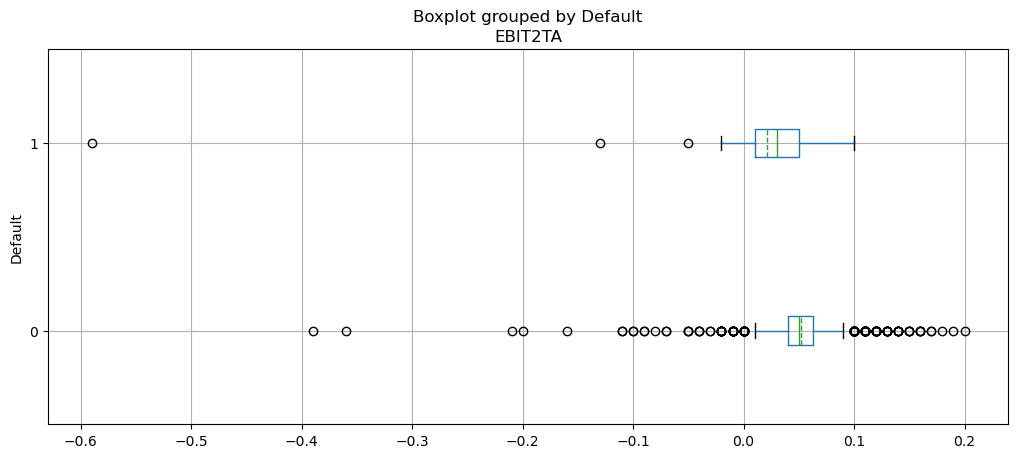

In [11]:
comp_data.boxplot('EBIT2TA', by='Default', grid=True, vert=False, meanline=True, showmeans=True, figsize=(12,5))
plt.show()

The difference in EBIT2TA is not significant. We can try to have a closer look at the range -0.1 to 0.1 where there are fewer outliers.

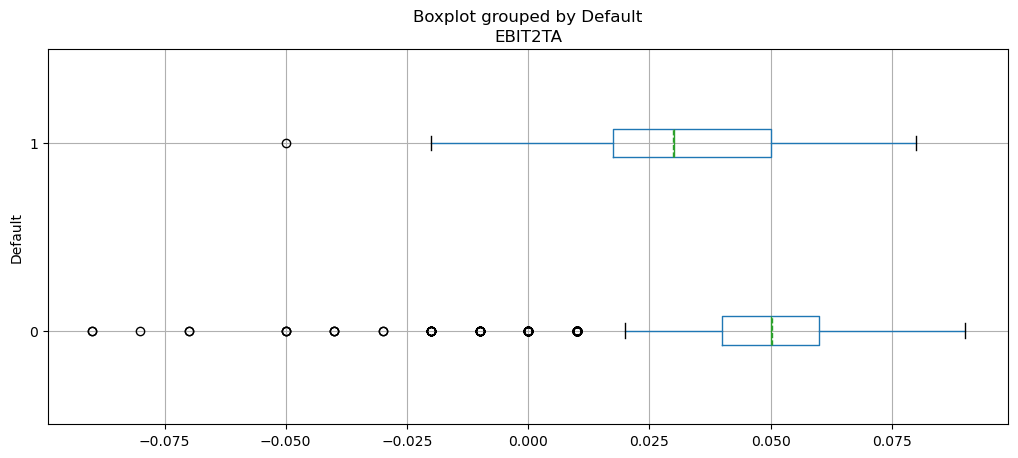

In [12]:
df_ebitta = comp_data[(comp_data['EBIT2TA'] < 0.1) & (comp_data['EBIT2TA'] > -0.1)]
df_ebitta.boxplot('EBIT2TA', by='Default', grid=True, vert=False, meanline=True, showmeans=True, figsize=(12,5))
plt.show()

Now we can see that non-default companies have a slightly higher EBIT2TA on average, with 50% of those are around 4-6%. Meanwhile, 50% of default companies have EBIT2TA in the range of 2-5%. The difference is however insignificant.


### ME2TL

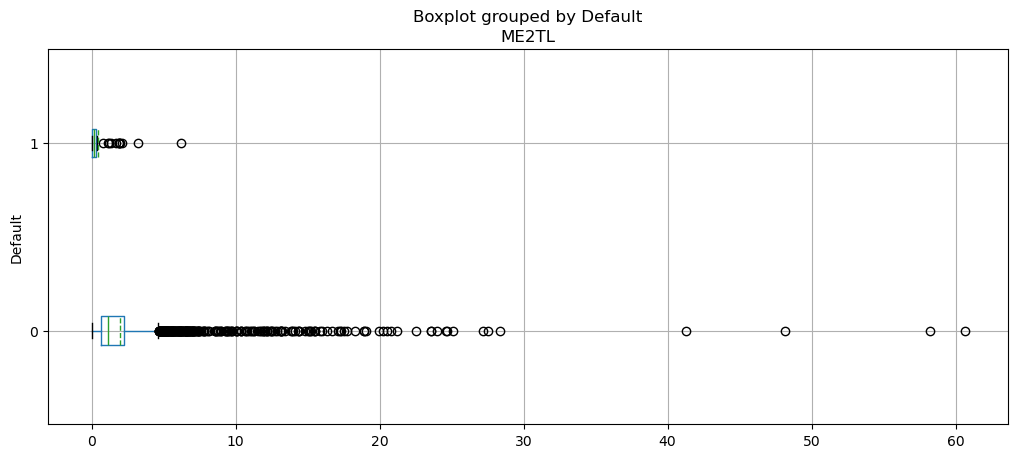

In [13]:
comp_data.boxplot('ME2TL', by='Default', grid=True, vert=False, figsize=(12,5), showfliers=True, showmeans=True, meanline=True)
plt.show()

Non-default companies usually have higher ME2TL. And if we remove observations where ME2TL > 4, we will have the following boxplot.

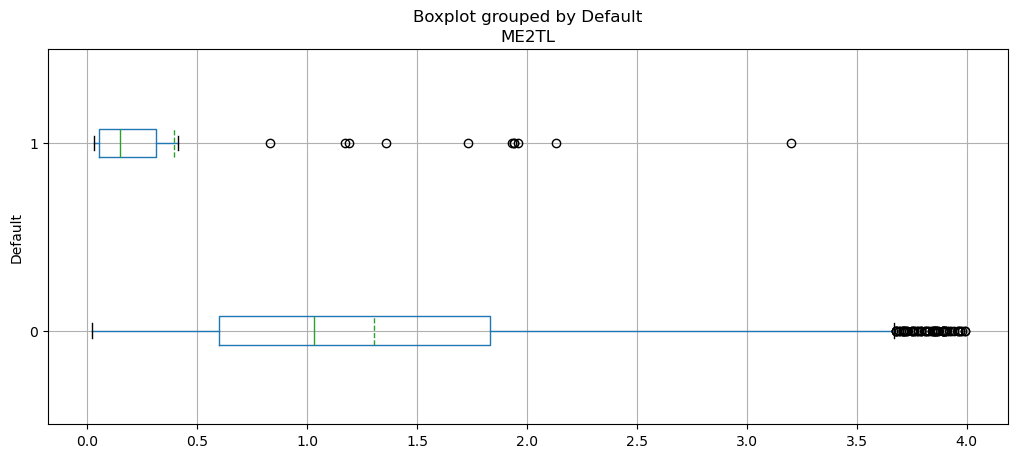

In [14]:
df1 = comp_data[comp_data['ME2TL']<4]
df1.boxplot('ME2TL', by='Default', grid=True, vert=False, figsize=(12,5), showfliers=True, showmeans=True, meanline=True)
plt.show()

Now it's easier to see that default companies have much lower ME2TL. Most of them have a ME2TL of lower than 0.4, whereas more than 75% of non-default companies have a ME2TL of higher than 0.6.

### S2TA

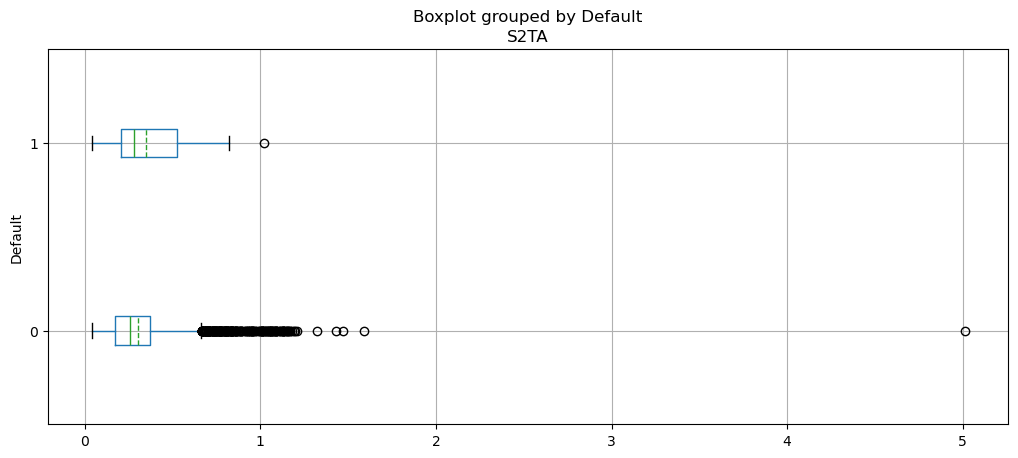

In [15]:
comp_data.boxplot('S2TA', by='Default', grid=True, vert=False, figsize=(12,5), showfliers=True, showmeans=True, meanline=True)
plt.show()

Let's remove some outliers with S2TA larger than 0.8 to see if we can get a better insight.

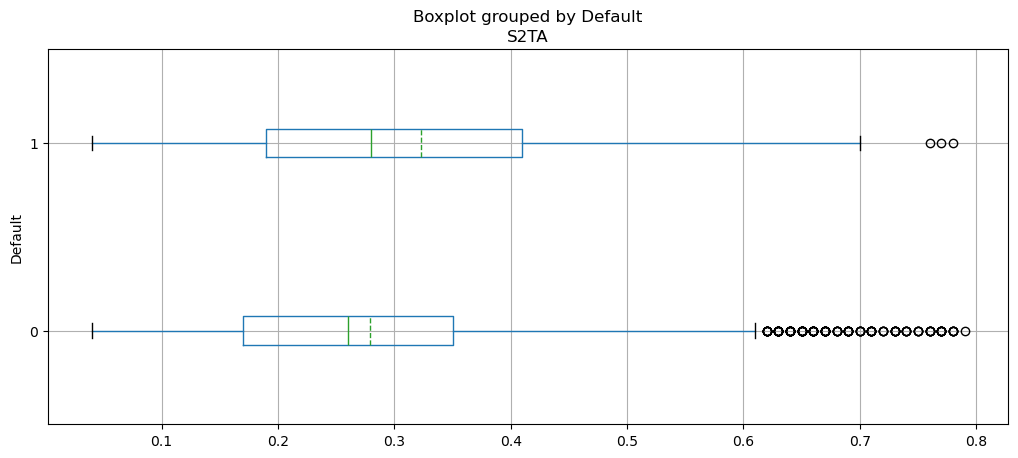

In [16]:
df_s2ta = comp_data[comp_data['S2TA'] < 0.8]
df_s2ta.boxplot('S2TA', by='Default', grid=True, vert=False, figsize=(12,5), showfliers=True, showmeans=True, meanline=True)
plt.show()

Oftentimes we think that companies with higher sales are doing better, and that's only generally true if holding everything else the same. But since we are looking at Sales/Total assets, it is not sufficient to comment on the company's ability to pay off its debt.

### Correlations among features

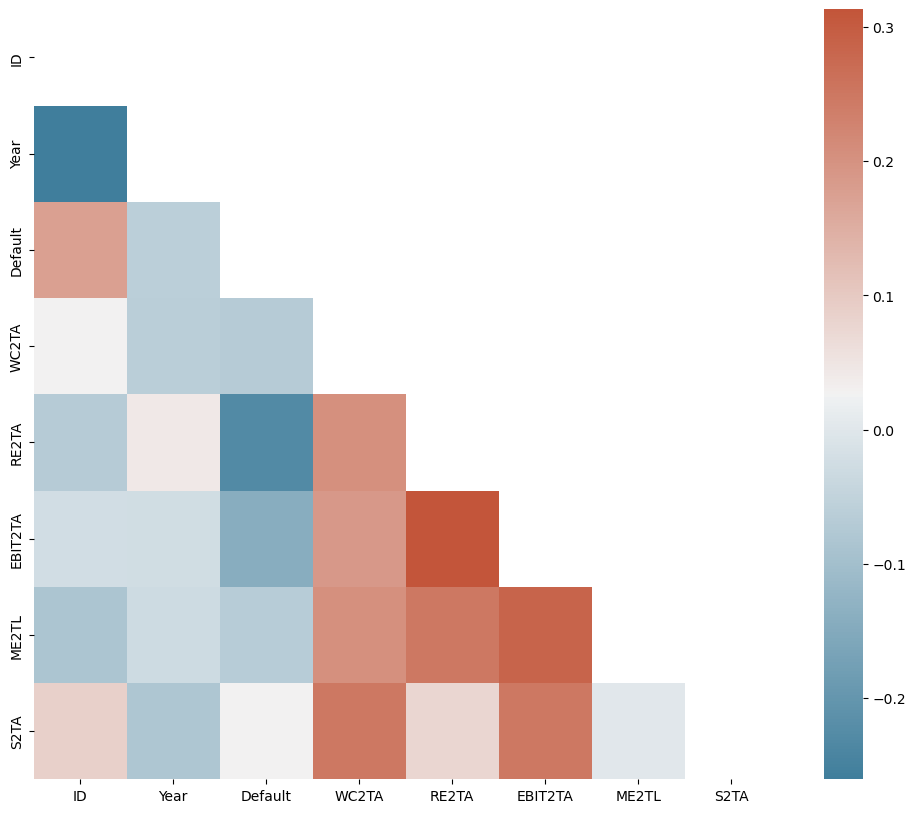

In [17]:
corr = comp_data.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap=cmap)
plt.show()

* The highest pair-wise correlation is 0.31, observed between EBIT2TA and RE2TA. 
* Surprisingly, S2TA has very low correlations with RE2TA and ME2TL.